In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time
import os
from tqdm import tqdm

In [2]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values[SMILES_COLUMN]]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

In [3]:

FILENAME = "test_predictions.csv"

SMILES_COLUMN = 'smiles'
ERROR_COLUMN = 'Squared Error'

FOLDS= 4

N_VALUES = 200

# Calculate best and worst molecules statistics

In [7]:
NUM_EXPS = [312, 313, 314, 315, 316, 317, 318, 319, 320, 321]

In [8]:
kruskal_stistics = []
for NUM_EXP in tqdm(NUM_EXPS):
    kruskal_stats = {}
    kruskal_stats_mean_std = {}
    
    DATA_PATH = "../../data/raw/baselines/dmpnn/logs/exp_"+str(NUM_EXP)+'/folds'
    rmse = []
    
    preds = []
    
    for FOLD in range(FOLDS):
        import json
        with open(os.path.join(DATA_PATH,'fold_'+str(FOLD), 'args.json'), 'r') as f:
            args = json.load(f)
        VALUE_COLUMNS = args['target_columns']
        PRED_COLUMNS = [value+'_pred' for value in args['target_columns']]
        if args['additional_encoder']:
            kruskal_stats_mean_std['Model'] = 'StructGNN with ext valence'
        else:
            kruskal_stats_mean_std['Model'] = 'DMPNN'
        kruskal_stats_mean_std['Num_exp'] = NUM_EXP
        kruskal_stats_mean_std['Data'] = ' '.join(args['target_columns'])
        
        kruskal_stats_mean_std['Dataset'] = args['separate_test_path']

        kruskal_stats_mean_std['Model'] += ' with '+' '.join(args['features_generator'][0].split('_'))
        
        for VALUE_COLUMN in VALUE_COLUMNS:
            if VALUE_COLUMN in kruskal_stats.keys():
                pass
            else:
                kruskal_stats[VALUE_COLUMN] = {}
                kruskal_stats[VALUE_COLUMN]['symmetric test RMSE'] = []
                kruskal_stats[VALUE_COLUMN]['symmetric test R2'] = []
                kruskal_stats[VALUE_COLUMN]['non-symmetric test RMSE'] = []
                kruskal_stats[VALUE_COLUMN]['non-symmetric test R2'] = []
                kruskal_stats[VALUE_COLUMN]['rmse']= []
                kruskal_stats[VALUE_COLUMN]['r2'] = []
            PRED_COLUMN = VALUE_COLUMN+'_pred'
            test_prediction = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(FOLD), FILENAME))
            kruskal_stats[VALUE_COLUMN]['rmse'].append(\
                                                       mean_squared_error(test_prediction[~test_prediction[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                                          test_prediction[~test_prediction[VALUE_COLUMN].isna()][PRED_COLUMN])**0.5)
            kruskal_stats[VALUE_COLUMN]['r2'].append(r2_score(\
                                                              test_prediction[~test_prediction[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                              test_prediction[~test_prediction[VALUE_COLUMN].isna()][PRED_COLUMN]))
            rmse.append(mean_squared_error(test_prediction[~test_prediction[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                           test_prediction[~test_prediction[VALUE_COLUMN].isna()][PRED_COLUMN])**0.5)
            

            test_prediction[ERROR_COLUMN] = (test_prediction[VALUE_COLUMN] - test_prediction[PRED_COLUMN]) ** 2    
            test_prediction_sorted = test_prediction.sort_values(by=[ERROR_COLUMN], ascending=False)    

            compare_data_with_stats = create_statistics(test_prediction_sorted)

            best_n_vals = compare_data_with_stats.iloc[-N_VALUES:]
            worst_n_vals = compare_data_with_stats.iloc[:N_VALUES]


            for stat in compare_data_with_stats.columns:
                if stat not in [SMILES_COLUMN, ERROR_COLUMN] and stat not in VALUE_COLUMNS and stat not in PRED_COLUMNS:
                    if stat not in kruskal_stats[VALUE_COLUMN].keys():
                        kruskal_stats[VALUE_COLUMN][stat] = []
                    kruskal_stats[VALUE_COLUMN][stat].append(stats.kruskal(best_n_vals[stat], worst_n_vals[stat])[1])

            symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or\
            (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))
            values_list = [pd.Series(Chem.CanonicalRankAtoms(Chem.MolFromSmiles(smiles), breakTies=False)).value_counts()\
                           for smiles in\
                           compare_data_with_stats[~compare_data_with_stats[VALUE_COLUMN].isna()][SMILES_COLUMN]]
            symmetric_indices = [symmetric_rull(values) for values in values_list]
            not_symmetric_indices = [not e for e in symmetric_indices]

            symmetric_y_predicted = compare_data_with_stats[~compare_data_with_stats[VALUE_COLUMN].isna()][PRED_COLUMN][symmetric_indices]
            symmetric_y_expected = compare_data_with_stats[~compare_data_with_stats[VALUE_COLUMN].isna()][VALUE_COLUMN][symmetric_indices]    
            not_symmetric_y_predicted = compare_data_with_stats[~compare_data_with_stats[VALUE_COLUMN].isna()][PRED_COLUMN][not_symmetric_indices]    
            not_symmetric_y_expected = compare_data_with_stats[~compare_data_with_stats[VALUE_COLUMN].isna()][VALUE_COLUMN][not_symmetric_indices]   

            from sklearn.metrics import mean_squared_error    

            kruskal_stats[VALUE_COLUMN]['symmetric test RMSE'].append(mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
            kruskal_stats[VALUE_COLUMN]['symmetric test R2'].append(r2_score(symmetric_y_expected, symmetric_y_predicted))


            kruskal_stats[VALUE_COLUMN]['non-symmetric test RMSE'].append(mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
            kruskal_stats[VALUE_COLUMN]['non-symmetric test R2'].append(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted))
        
    
    for VALUE in kruskal_stats.keys():
        for stat in kruskal_stats[VALUE].keys():
            kruskal_stats_mean_std[VALUE+'_'+stat+'_mean'] = np.mean(kruskal_stats[VALUE][stat])
            kruskal_stats_mean_std[VALUE+'_'+stat+'_std'] = np.std(kruskal_stats[VALUE][stat])
    
    kruskal_stistics.append(kruskal_stats_mean_std)
    
kruskal_stistics = pd.DataFrame(kruskal_stistics)

import math
for i in range(len(kruskal_stistics)):
    stats_model = kruskal_stistics.iloc[i]
    print(stats_model['Num_exp'])
    print(stats_model['Model'])
    print(stats_model['Data'])
    print(stats_model['Dataset'])
    print()
    output = {}
    for stat in stats_model.keys():
        if stat=='Model' or stat=='Data' or stat=='Dataset' or stat=='Num_exp':
            continue
        stat_name = '_'.join(stat.split('_')[:-1])
        stat_suf = stat.split('_')[-1]
        if stat_name not in output.keys():
            output[stat_name] = {}
        output[stat_name][stat_suf] = stats_model[stat]
    for stat in output.keys():
        if math.isnan(output[stat]['mean']):
            continue
        print(stat,' = ', round(output[stat]['mean'],3), '+/-', round(output[stat]['std'], 3))
    print()
    print('===')
    print()

 70%|███████   | 7/10 [10:52<06:25, 128.49s/it]/home/mol/anaconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/mol/anaconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/mol/anaconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/mol/anaconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
 90%|█████████ | 9/10 [14:55<02:10, 130.54s/it]/home/

312
DMPNN with rdkit wo fragments and counts
logD
./data/3_final_data/split_data/logd_Lip_wo_averaging_test.csv

logD_symmetric test RMSE  =  0.979 +/- 0.194
logD_symmetric test R2  =  0.26 +/- 0.313
logD_non-symmetric test RMSE  =  0.584 +/- 0.02
logD_non-symmetric test R2  =  0.764 +/- 0.016
logD_rmse  =  0.589 +/- 0.02
logD_r2  =  0.76 +/- 0.016
logD_atom_count  =  0.324 +/- 0.235
logD_ring_count  =  0.578 +/- 0.313
logD_non_organogens_count  =  0.495 +/- 0.377
logD_non_organogens_percent  =  0.412 +/- 0.274
logD_aromatic_count  =  0.374 +/- 0.36
logD_aromatic_rings_percent  =  0.532 +/- 0.302
logD_bond_count  =  0.506 +/- 0.316
logD_aromatic_bond_count  =  0.552 +/- 0.111
logD_aromatic_bond_percent  =  0.576 +/- 0.185
logD_is_symmetric  =  0.125 +/- 0.056

===

313
StructGNN with ext valence with rdkit wo fragments and counts
logD
./data/3_final_data/split_data/logd_Lip_wo_averaging_test.csv

logD_symmetric test RMSE  =  1.113 +/- 0.147
logD_symmetric test R2  =  0.064 +/- 0.242
lo

logP_ring_count  =  0.62 +/- 0.193
logP_non_organogens_count  =  0.579 +/- 0.198
logP_non_organogens_percent  =  0.63 +/- 0.183
logP_aromatic_count  =  0.679 +/- 0.218
logP_aromatic_rings_percent  =  0.559 +/- 0.24
logP_bond_count  =  0.0 +/- 0.0
logP_aromatic_bond_count  =  0.255 +/- 0.194
logP_aromatic_bond_percent  =  0.083 +/- 0.134
logP_is_symmetric  =  0.202 +/- 0.13

===

321
DMPNN with rdkit 2d normalized best
logD logP
./data/3_final_data/split_data/logd_258_Logp_wo_averaging_test.csv

logD_symmetric test RMSE  =  0.634 +/- 0.144
logD_symmetric test R2  =  0.533 +/- 0.194
logD_non-symmetric test RMSE  =  0.63 +/- 0.039
logD_non-symmetric test R2  =  0.721 +/- 0.034
logD_rmse  =  0.63 +/- 0.039
logD_r2  =  0.72 +/- 0.034
logD_atom_count  =  0.398 +/- 0.239
logD_ring_count  =  0.443 +/- 0.314
logD_non_organogens_count  =  0.407 +/- 0.355
logD_non_organogens_percent  =  0.362 +/- 0.313
logD_aromatic_count  =  0.766 +/- 0.067
logD_aromatic_rings_percent  =  0.535 +/- 0.255
logD_bo

# Calculate correlation between logD and logP predictions in multitask

In [24]:
NUM_EXPS= [317]

In [37]:
correlation_mean_std = {}
correlation_mean_std['Pearson\'s r'] = {}
correlation_mean_std['Spearman\'s rho'] = {}
correlation_mean_std['Kendall\'s tau'] = {}
for NUM_EXP in tqdm(NUM_EXPS):
    DATA_PATH = "../../data/raw/baselines/dmpnn/logs/exp_"+str(NUM_EXP)+'/folds'
    rmse = []
    
    correlation = {}
    correlation['Pearson\'s r'] = []
    correlation['Spearman\'s rho'] = []
    correlation['Kendall\'s tau'] = []

    for FOLD in range(FOLDS):
        import json
        with open(os.path.join(DATA_PATH,'fold_'+str(FOLD), 'args.json'), 'r') as f:
            args = json.load(f)
        VALUE_COLUMNS = args['target_columns']
        PRED_COLUMNS = [value+'_pred' for value in args['target_columns']]
        
        test_prediction = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(FOLD), FILENAME))
        preds_0 = test_prediction[PRED_COLUMNS[0]]
        preds_1 = test_prediction[PRED_COLUMNS[1]]
        smiles = test_prediction[~test_prediction[VALUE_COLUMN].isna()][SMILES_COLUMN]
        values = test_prediction[~test_prediction[VALUE_COLUMN].isna()][VALUE_COLUMN]


        correlation['Pearson\'s r'].append(preds_0.corr(preds_1))
        correlation['Spearman\'s rho'].append(preds_0.corr(preds_1, method='spearman'))
        correlation['Kendall\'s tau'].append(preds_0.corr(preds_1, method='kendall'))
        
for method in correlation.keys():
    correlation_mean_std[method]['mean'] = np.mean(correlation[method])
    correlation_mean_std[method]['std'] = np.std(correlation[method])
    
for method in correlation_mean_std.keys():
    print(method, ' correlation = ', \
          round(correlation_mean_std[method]['mean'], 3)\
          ,'+/-',\
          round(correlation_mean_std[method]['std'], 3))

100%|██████████| 1/1 [00:00<00:00, 20.66it/s]

Pearson's r  correlation =  0.802 +/- 0.014
Spearman's rho  correlation =  0.859 +/- 0.004
Kendall's tau  correlation =  0.688 +/- 0.006


# LogP DMPNN model analysis

# Get predictions

## Average ensemble of models

In [95]:
SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logD'
PRED_COLUMN = 'logD_pred'
ERROR_COLUMN = 'Squared Error'


preds = []

for FOLD in range(FOLDS):
    test_prediction = pd.read_csv('../../data/4_best_baselines_predictions/dmpnn/logp_wo_averaging_test_preds.csv')
    preds.append(test_prediction[PRED_COLUMN].values)
    smiles = test_prediction[SMILES_COLUMN]
    values = test_prediction[VALUE_COLUMN]
    
test_prediction = pd.DataFrame(columns = [SMILES_COLUMN, PRED_COLUMN, VALUE_COLUMN])
test_prediction[SMILES_COLUMN] = smiles
test_prediction[VALUE_COLUMN] = values
test_prediction[PRED_COLUMN] = np.mean(np.array(preds), axis = 0)

In [96]:
test_prediction.head()

,smiles,logP_pred,logP
0,CC(=O)NC(Cc1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)N(C)...,2.418475,2.63
1,CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2...,3.829421,4.17
2,CCS(=O)c1sc(C(C)=O)c(N)c1C#N,1.896444,1.82
3,O=P(Oc1ccccc1)(Oc1ccccc1)Oc1ccccc1,4.344720,4.59
4,OC1(c2cc(Cl)ccc2Cl)CCCCC1n1cncn1,3.327758,3.24


In [97]:
print('Test RMSE = ', mean_squared_error(test_prediction[VALUE_COLUMN], test_prediction[PRED_COLUMN])**0.5)

Test RMSE =  0.44085248822198


## Average scores

In [100]:
rmse = []
for FOLD in range(FOLDS):
    test_prediction = pd.read_csv('../../data/4_best_baselines_predictions/dmpnn/logp_wo_averaging_test_preds.csv')
    rmse.append(mean_squared_error(test_prediction[VALUE_COLUMN], test_prediction[PRED_COLUMN])**0.5)

print('All RMSE ', rmse)
print('Test RMSE = ', np.mean(rmse))

All RMSE  [0.44085248822198, 0.44085248822198, 0.44085248822198, 0.44085248822198]
Test RMSE =  0.44085248822198


## Calculate error

In [101]:
ERROR_COLUMN = 'Squared Error'

In [102]:
test_prediction = pd.read_csv('../../data/4_best_baselines_predictions/dmpnn/logp_wo_averaging_test_preds.csv')

In [103]:
test_prediction[ERROR_COLUMN] = (test_prediction[VALUE_COLUMN] - test_prediction[PRED_COLUMN]) ** 2

In [104]:
test_prediction_sorted = test_prediction.sort_values(by=[ERROR_COLUMN], ascending=False)

In [105]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values[SMILES_COLUMN]]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

In [106]:
compare_data_with_stats = create_statistics(test_prediction_sorted)

In [139]:
compare_data_with_stats.tail()

,smiles,logP,logP_pred,Squared Error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
925,Cc1ncc([N+](=O)[O-])n1CCS(C)(=O)=O,-0.82,-0.820723,5.230613e-07,17,2,1,5.882353,2,100.000000,15,5,33.333333,False
42,COc1cccc(CC(C)N)c1OC,1.49,1.489322,4.602563e-07,23,3,2,8.695652,1,33.333333,14,6,42.857143,False
1729,COP(=S)(NC(C)C)Oc1ccc(Cl)cc1Cl,4.30,4.299360,4.089857e-07,14,4,0,0.000000,0,0.000000,17,6,35.294118,False
2060,[O-][n+]1onc(-c2ccccc2)c1Cl,2.70,2.699795,4.213496e-08,9,1,0,0.000000,0,0.000000,14,11,78.571429,False
1093,OCCc1ccncc1,0.10,0.100122,1.484384e-08,19,2,5,26.315789,2,100.000000,9,6,66.666667,False


# Get best and worst predictions

In [108]:
n_values = 200

In [109]:
best_n_vals = compare_data_with_stats.iloc[-n_values:]

In [141]:
worst_n_vals.sort_values(by = [ERROR_COLUMN],ascending = False)

,smiles,logP,logP_pred,Squared Error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,6.352609,18.426489,19,2,2,10.526316,1,50.0,18,0,0.000000,False
1730,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-3.775163,16.770356,11,1,0,0.000000,1,100.0,16,0,0.000000,True
1824,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,2.959373,10.044923,20,1,0,0.000000,0,0.0,24,12,50.000000,False
637,O=S(=O)(O[Na])c1cc(-n2nc3ccc4ccccc4c3n2)ccc1C=...,1.80,-0.945304,7.536693,18,1,3,16.666667,1,100.0,36,27,75.000000,False
658,CC1OC(OC2C(O)CC(OC3C(O)CC(OC4CCC5(C)C(CCC6C5CC...,-1.77,0.926779,7.272619,16,1,1,6.250000,1,100.0,74,5,6.756757,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,O=C(O)C(c1ccc(-c2ccccc2)cc1)C(O)c1cccc(F)c1,3.31,3.950504,0.410245,12,1,0,0.000000,1,100.0,27,18,66.666667,False
488,C=CCn1c(SCC(=O)N2C[C@@]3(C)C[C@@H]2CC(C)(C)C3)...,6.04,6.678596,0.407805,11,1,0,0.000000,0,0.0,33,10,30.303030,False
289,CC#Cc1cc(C)[nH]c(=Nc2ccccc2)n1,3.28,3.916718,0.405410,7,0,1,14.285714,0,0.0,18,12,66.666667,False
1559,CCOC(=O)C(Cc1ccoc1)=NC=O,2.08,1.445709,0.402325,10,2,0,0.000000,1,50.0,15,5,33.333333,False


In [110]:
worst_n_vals = compare_data_with_stats.iloc[:n_values]

# Get Kruskal Stats

In [111]:
print(stats.kruskal(best_n_vals.atom_count, worst_n_vals.atom_count))

KruskalResult(statistic=2.503076453575314, pvalue=0.11362414365070286)


<AxesSubplot:xlabel='atom_count'>

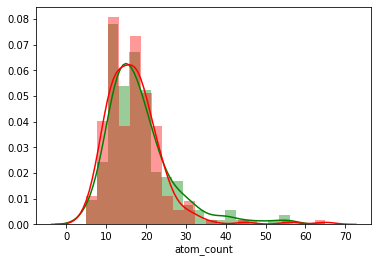

In [112]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

In [113]:
print(stats.kruskal(best_n_vals.ring_count, worst_n_vals.ring_count))

KruskalResult(statistic=2.4772490765201196, pvalue=0.11550411585688974)


<AxesSubplot:xlabel='ring_count'>

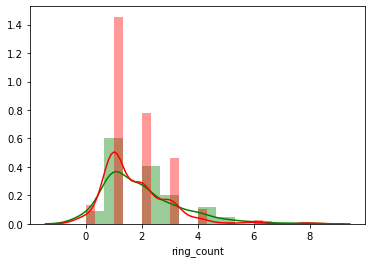

In [114]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

In [115]:
print(stats.kruskal(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

KruskalResult(statistic=0.3427930041983832, pvalue=0.5582214665697456)


<AxesSubplot:xlabel='non_organogens_count'>

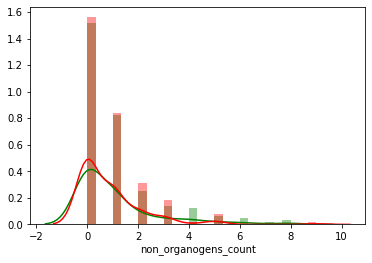

In [116]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

In [117]:
print(stats.kruskal(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

KruskalResult(statistic=0.1471269545413422, pvalue=0.7012962031583021)


<AxesSubplot:xlabel='non_organogens_percent'>

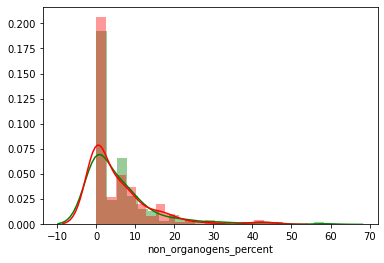

In [118]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

In [119]:
print(stats.kruskal(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

KruskalResult(statistic=2.317463149797452, pvalue=0.12792851052699947)


<AxesSubplot:xlabel='aromatic_count'>

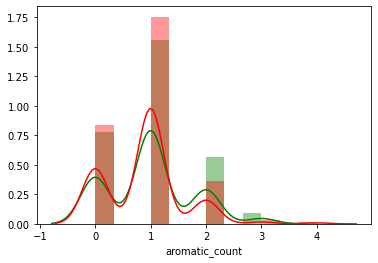

In [120]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

In [121]:
print(stats.kruskal(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

KruskalResult(statistic=0.09733631334489745, pvalue=0.7550498852400577)


<AxesSubplot:xlabel='aromatic_rings_percent'>

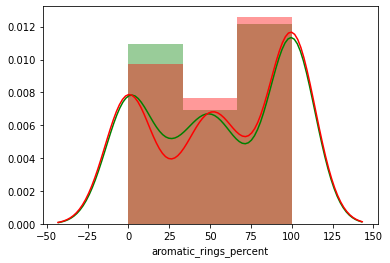

In [122]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

In [123]:
print(stats.kruskal(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

KruskalResult(statistic=21.537314181354503, pvalue=3.4701051685614547e-06)


<AxesSubplot:xlabel='aromatic_bond_percent'>

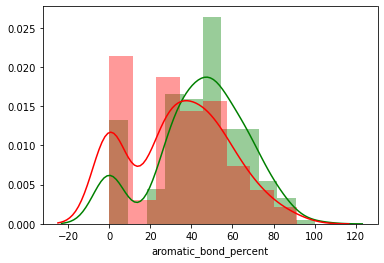

In [124]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

In [125]:
print(stats.kruskal(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

KruskalResult(statistic=0.24278454096355018, pvalue=0.6222021666954054)


<AxesSubplot:xlabel='aromatic_bond_count'>

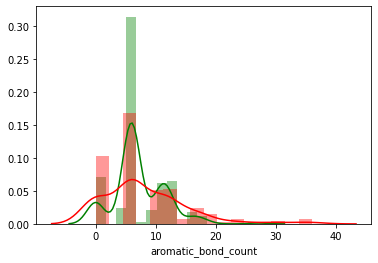

In [126]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

# Symmetric metrics

In [127]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [128]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(Chem.MolFromSmiles(smiles), breakTies=False)).value_counts() for smiles in compare_data_with_stats[SMILES_COLUMN]]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [129]:
symmetric_y_predicted = compare_data_with_stats[PRED_COLUMN][symmetric_indices]


In [130]:
symmetric_y_expected = compare_data_with_stats[VALUE_COLUMN][symmetric_indices]

In [131]:
not_symmetric_y_predicted = compare_data_with_stats[PRED_COLUMN][not_symmetric_indices]

In [132]:
not_symmetric_y_expected = compare_data_with_stats[VALUE_COLUMN][not_symmetric_indices]

In [133]:
from sklearn.metrics import mean_squared_error

In [134]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 0.7664073064955048
Test symmetric R2-score is 0.8891239875706615


In [135]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.42470038526469506
Test not symmetric R2-score is 0.9448009547313081
